In [1]:
import numpy as np
from scipy import signal
from scipy.ndimage import filters

from matplotlib import pyplot as plt

# Load data

In [2]:
file_name = 'Ntuple_runsampic_166_runtelescope_643.npy'
events = np.load(f'../data/{file_name}', allow_pickle=True).flat[0]

events.keys()

dict_keys(['eventIDSampic', 'sample_channel', 'num_samples', 'sample_ampl', 'sample_time'])

# CFD

In [133]:
def cfd(time, voltage, threshold=5000, base_line=200, fraction=0.3, smooth=False, kernel_width=10, kernel_sigma=5, hysteresis=1000, chooseFirst=True):
    samples = voltage.astype(float)
    # If peak2peak < threshold there is no peak for sure...
    if samples.max()-samples.min() < threshold:
        print(f'        peak2peak < threshold')
        return None
    if smooth:
        kernel = signal.gaussian(kernel_width, kernel_sigma)
        samples = filters.convolve(samples, kernel)
        
    # Work only with positive and normalized signals 
    samples -= np.mean(samples[:base_line])
    if abs(samples.max()) < abs(samples.min()):
        maximum = abs(samples.min())
        samples *= -1/maximum
    else:
        maximum = samples.max()
        samples *= 1/maximum
        
    #threshold = threshold/maximum
    hysteresis = hysteresis/maximum
    
    above = False
    lockedForHysteresis = False
    numberOfPeaks = 0
    for i,v in enumerate(samples):
        #print("%d: %.3f"%(i,v))
        if not above and not lockedForHysteresis and v>fraction:
            firstCrossingIndex = i
            above = True
            lockedForHysteresis = True
            if chooseFirst:
                numberOfPeaks += 1
                above = False
                break
        if above and lockedForHysteresis and v>fraction+hysteresis:
            lockedForHysteresis = False
        if above and not lockedForHysteresis and v<fraction:
            numberOfPeaks += 1
            above = False
    if numberOfPeaks==1:
        t1 = time[firstCrossingIndex]
        t2 = time[firstCrossingIndex-1]
        v1 = samples[firstCrossingIndex]
        v2 = samples[firstCrossingIndex-1]
        return (t1 + (t2 - t1)*(fraction-v1)/(v2 - v1))
    else:
        print(f'        number of peaks: {numberOfPeaks}')
        return None

# Tests (single event)

In [134]:
i_event = 5676

print(f"Sampic event: {events['eventIDSampic'][i_event]}")
print(f"Channels: {events['sample_channel'][i_event]}")

event_channel = events['sample_channel'][i_event]

Sampic event: 22879
Channels: [11 23  0 29]


In [135]:
def flip_Y(X):
    # return X
    return (X - 1) * - 1

event_ampl = flip_Y(events['sample_ampl'][i_event])

# event_time = events['sample_time'][i_event]
event_time = np.tile(np.arange(64), (len(event_ampl), 1))

event_ampl.shape, event_time.shape

((4, 64), (4, 64))

In [136]:
baseline = 20
event_threshold = np.std(event_ampl[:, :baseline], axis=1) * 6
event_hysteresis = event_threshold / 100

event_cfd_timestamps = []
for i in range(len(event_ampl)):
    ampl = event_ampl[i]
    time = event_time[i]
    threshold = event_threshold[i]
    hysteresis = event_hysteresis[i]
    
    timestamp = cfd(time, ampl, threshold=threshold, base_line=baseline, hysteresis=hysteresis)
    event_cfd_timestamps.append(timestamp)
    
print(event_cfd_timestamps)

[34.96397403972108, 33.714441069051354, 31.363676533275395, 28.06987062081711]


In [137]:
def plot_sample(time, ampl, title='', timestamp=None, ylim=False):
    plt.plot(time, ampl)
    if ylim:
        plt.ylim(-0.1, 1.1)
    if timestamp is not None:
        plt.axvline(timestamp, c='red')
        title += f', timestamp={timestamp:0.2f}'
    plt.title(title)
    if ylim:
        plt.ylim(-0.1, 1.1)

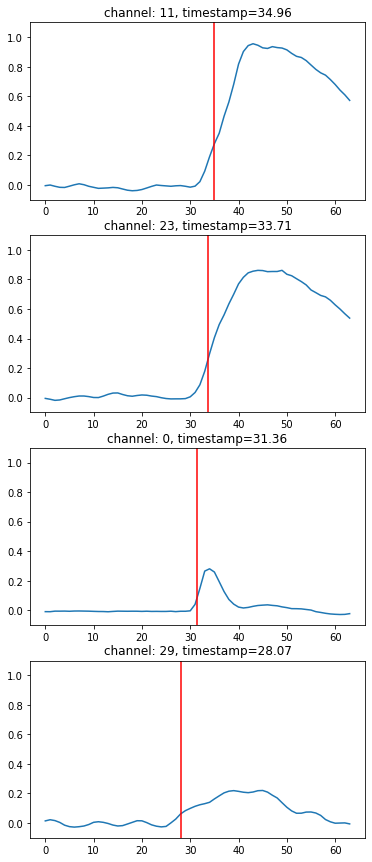

In [138]:
plt.figure(figsize=(6, 15))
for i, (ampl, time, timestamp, channel) in enumerate(zip(event_ampl, event_time, event_cfd_timestamps, event_channel)):
    plt.subplot(4, 1, i + 1)
    plot_sample(time, ampl, title=f'channel: {channel}', timestamp=timestamp, ylim=True)

# Tests (a few events)

In [139]:
# selected_events = []
# while len(selected_events) < 4:
#     i_event = np.random.choice(np.arange(len(events['num_samples'])))
#     if events['num_samples'][i_event] == 4 and 0 in events['sample_channel'][i_event]:
#         selected_events.append(i_event)
    
# selected_events = [300914, 149867, 219162, 24642]
selected_events = [315019, 67827, 137328, 331510]
selected_events

[315019, 67827, 137328, 331510]

In [146]:
def calculate_event_cfd(i_event, baseline=20):
    event_ampl = flip_Y(events['sample_ampl'][i_event])
    event_time = np.tile(np.arange(64), (len(event_ampl), 1))
    
    event_threshold = np.std(event_ampl[:, :baseline], axis=1) * 6
    # event_threshold = [0.5] * 4
    event_hysteresis = event_threshold / 10
    # event_hysteresis = [0.1] * 4
    print('hysteresis:', event_hysteresis)

    event_cfd_timestamps = []
    for i in range(len(event_ampl)):
        ampl = event_ampl[i]
        time = event_time[i]
        threshold = event_threshold[i]
        hysteresis = event_hysteresis[i]

        print('    sample', i)
        timestamp = cfd(time, ampl, threshold=threshold, base_line=baseline, hysteresis=hysteresis, fraction=0.3, chooseFirst=True)
        event_cfd_timestamps.append(timestamp)

    return event_cfd_timestamps

event 0
hysteresis: [0.0091019  0.01529522 0.00061111 0.0052646 ]
    sample 0
    sample 1
    sample 2
    sample 3
event 1
hysteresis: [0.00828448 0.0089424  0.00056425 0.01005291]
    sample 0
    sample 1
    sample 2
    sample 3
event 2
hysteresis: [0.01276277 0.0083652  0.01277167 0.00090906]
    sample 0
    sample 1
    sample 2
    sample 3
event 3
hysteresis: [0.0094593  0.00063084 0.00868477 0.00705464]
    sample 0
    sample 1
    sample 2
    sample 3


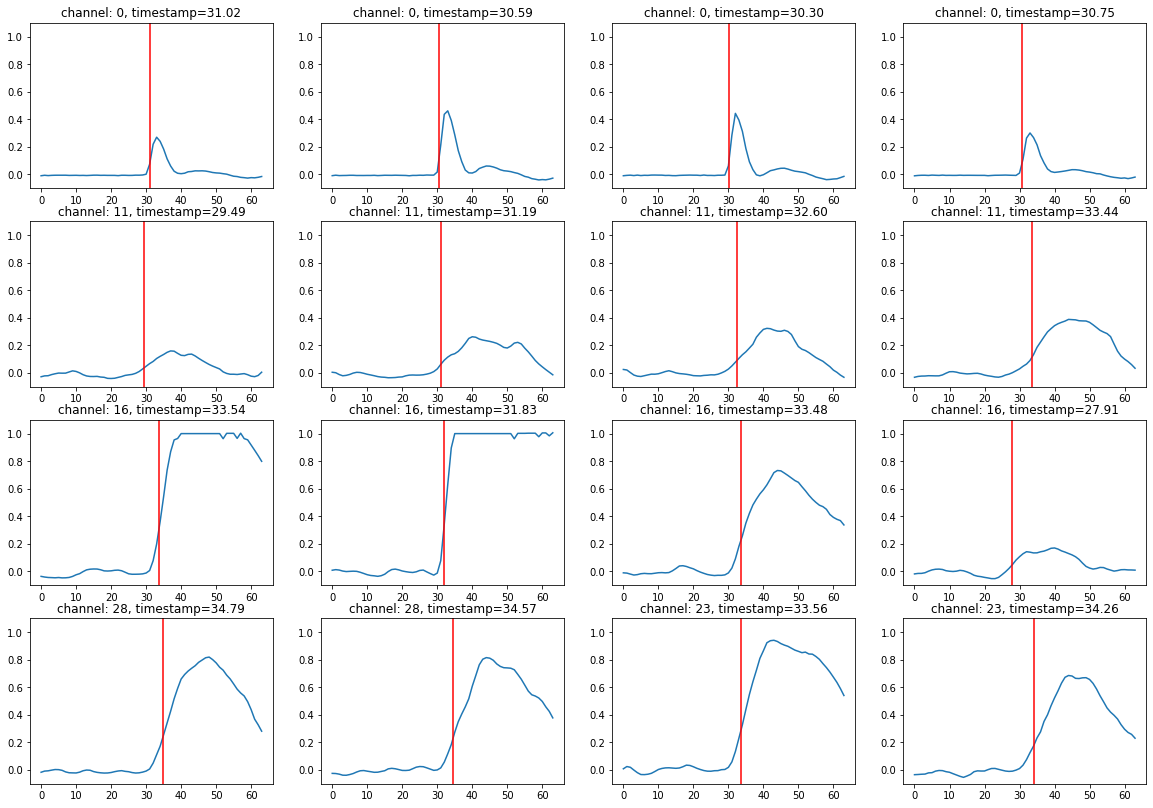

In [147]:
plt.figure(figsize=(20, 14))
for i, i_event in enumerate(selected_events):
    event_channels = events['sample_channel'][i_event]
    arg_sorted = list(np.argsort(event_channels))
    event_channels = event_channels[arg_sorted]
    
    event_ampl = flip_Y(events['sample_ampl'][i_event])[arg_sorted]
    event_time = np.tile(np.arange(64), (len(event_ampl), 1))[arg_sorted]
    
    print('event', i)
    event_cfd_timestamps = np.array(calculate_event_cfd(i_event))[arg_sorted]
    
    for j in range(4):
        plt.subplot(4, 4, j * 4 + i + 1)
        plot_sample(event_time[j], event_ampl[j], title=f'channel: {event_channels[j]}', timestamp=event_cfd_timestamps[j], ylim=True)

In [149]:
# events